## README

The origins of this notebook are a result of me being encouraged time and time again to "get on the property ladder"; and at the same time finding it hard to understand how a non-productive asset could generate economic value competitive with the greatest economy the world has ever seen.

The combination of low (and then lower) interest rates vs. historical averages, along with inflationary restrictions on land consumption made 1995-2015 a vintage (if bumpy) era for "property investors" and that much is clear from the data. Post-2015 the picture is fuzzy. When controlling for inflation, prices have been flat in a lot of postcodes while the S&P has ripped. Many who bought in 2019 have lost out relative to those who held onto their ISAs.

Apparently there's more to life than net worth optimisation but there is a serious point to be made in here for everyone of my generation (~30 ans) who grew up being told that taking out the biggest mortgages possible on the most expensive property they could afford was the only thing to do. Indeed for much of recent history that strategy has been a winner - the more housing you consumed, the more money you made - but that situation is clearly unsustainable. Normality seems to have returned to the market and there now seem to be (as there should be) real costs of owning depreciating, non-productive assets vs. shares in what should be productive enterprises. The previous generations' truisms about the housing market no longer seem to hold, so think carefully before you buy and hopefully some of the info in here is of use to you.

### Usage

Set your variables in the first cell and then everything should just run. You can set:

- Postcode (outcode, or incode and outcode)
- Property type(s)
- A starting year that'll also be used to baseline the indicies (has to be post 1995 I think)
- A rental yield for property total return calculations
- Apply an inflation adjustment

Property price data is from Land Registry and I think this kind of thing is permitted in their license. If anything's broken or you'd like me to extend this, just drop me a line.

In [ ]:
# Inputs

# Include a space if you want to search for a specific incode e.g. SE5 7TG
postcode = "NW1"

# > 1995
start_year = 2005

# Comment as required
property_types = [
    # "detached",
    # "semi-detached",
    # "terraced",
    "flat-maisonette",
    # "otherPropertyType",
]

max_price = 2_000_000
min_price = 0

rental_yield = 0.05

inflation_adjust = True

In [ ]:
sparql_query = """
PREFIX  op:   <http://environment.data.gov.uk/reference/def/op/>
PREFIX  rt:   <http://environment.data.gov.uk/flood-monitoring/def/core/>
PREFIX  owl:  <http://www.w3.org/2002/07/owl#>
PREFIX  ppd:  <http://landregistry.data.gov.uk/def/ppi/>
PREFIX  xsd:  <http://www.w3.org/2001/XMLSchema#>
PREFIX  skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX  ukhpi: <http://landregistry.data.gov.uk/def/ukhpi/>
PREFIX  rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX  local: <http://localhost/def/>
PREFIX  geo:  <http://www.w3.org/2003/01/geo/wgs84_pos#>
PREFIX  core: <http://environment.data.gov.uk/reference/def/core/>
PREFIX  dct:  <http://purl.org/dc/terms/>
PREFIX  wfd:  <http://environment.data.gov.uk/catchment-planning/def/water-framework-directive/>
PREFIX  rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX  lrcommon: <http://landregistry.data.gov.uk/def/common/>
PREFIX  api:  <http://purl.org/linked-data/api/vocab#>
PREFIX  admingeo: <http://data.ordnancesurvey.co.uk/ontology/admingeo/>
PREFIX  dc:   <http://purl.org/dc/elements/1.1/>
PREFIX  sr:   <http://data.ordnancesurvey.co.uk/ontology/spatialrelations/>
PREFIX  sosa: <http://www.w3.org/ns/sosa/>

SELECT  ?id ?propertyAddress ?propertyAddress_county ?propertyAddress_district ?propertyAddress_locality ?propertyAddress_paon ?propertyAddress_postcode ?propertyAddress_saon ?propertyAddress_street ?propertyAddress_town ?newBuild ?estateType ?transactionCategory ?pricePaid ?transactionDate ?propertyType ?hasTransaction ?transactionId ?recordStatus
WHERE
  { { SELECT DISTINCT  ?id
      WHERE
        { { SELECT DISTINCT  ?propertyAddress
            WHERE
              { ?propertyAddress
                          <http://jena.apache.org/text#query>  ( "postcode: $postcode" 3000000 )}
          }
          ?id  ppd:propertyAddress  ?propertyAddress .
          ?id  rdf:type  ppd:TransactionRecord .
          ?id  ppd:pricePaid  ?pricePaid
          FILTER ( ( ?pricePaid <= $max_price ) || ( ( ! ( datatype(?pricePaid) = xsd:integer ) ) && ( xsd:integer(?pricePaid) <= $max_price ) ) )
          ?id  ppd:transactionDate  ?transactionDate
          FILTER ( ?transactionDate <= "2024-10-12"^^xsd:date )
          FILTER ( ( ?pricePaid >= $min_price ) || ( ( ! ( datatype(?pricePaid) = xsd:integer ) ) && ( xsd:integer(?pricePaid) >= $min_price ) ) )
          FILTER ( ?transactionDate >= "$start_year-01-01"^^xsd:date )
          ?id  ppd:propertyType  ?propertyType
          FILTER ( ?propertyType IN ($property_type_filter) )
        }
      LIMIT  100000
    }
    ?id  ppd:propertyAddress  ?propertyAddress
    OPTIONAL
      { ?propertyAddress
                  lrcommon:county  ?propertyAddress_county}
    OPTIONAL
      { ?propertyAddress
                  lrcommon:district  ?propertyAddress_district}
    OPTIONAL
      { ?propertyAddress
                  lrcommon:locality  ?propertyAddress_locality}
    OPTIONAL
      { ?propertyAddress
                  lrcommon:paon  ?propertyAddress_paon}
    OPTIONAL
      { ?propertyAddress
                  lrcommon:postcode  ?propertyAddress_postcode}
    OPTIONAL
      { ?propertyAddress
                  lrcommon:saon  ?propertyAddress_saon}
    OPTIONAL
      { ?propertyAddress
                  lrcommon:street  ?propertyAddress_street}
    OPTIONAL
      { ?propertyAddress
                  lrcommon:town  ?propertyAddress_town}
    ?id  ppd:newBuild          ?newBuild ;
         ppd:transactionCategory  ?transactionCategory ;
         ppd:pricePaid         ?pricePaid ;
         ppd:transactionDate   ?transactionDate ;
         ppd:hasTransaction    ?hasTransaction ;
         ppd:transactionId     ?transactionId
    OPTIONAL
      { ?id  ppd:estateType  ?estateType}
    OPTIONAL
      { ?id  ppd:propertyType  ?propertyType}
    OPTIONAL
      { ?id  ppd:recordStatus  ?recordStatus}
  }
"""

In [ ]:
# Load data from Land Registry

from string import Template
import requests
import json

query_template = Template(sparql_query)

template_vars = {
    "postcode": postcode if len(postcode.split(" ")) == 1 else f"({postcode.split(' ')[0]} AND {postcode.split(' ')[1]})",
    "property_type_filter": ", ".join([f"lrcommon:{x}" for x in property_types]),
    "min_price": min_price,
    "max_price": max_price,
    "start_year": start_year
}

resp = requests.post("https://landregistry.data.gov.uk/qonsole/query",
                     data={"q": query_template.substitute(template_vars)})

if resp.status_code not in range(200, 300):
    raise ValueError("SPARQL endpoint returned a non-success status code")
body_json = resp.json()
body = json.loads(body_json["result"])

In [ ]:
# Process inflation data

import pandas as pd

inf = pd.read_csv("https://hcee-static-prod.s3.eu-west-2.amazonaws.com/docs/inflation.csv")

months = {
    'JAN': 1,
    'FEB': 2,
    'MAR': 3,
    'APR': 4,
    'MAY': 5,
    'JUN': 6,
    'JUL': 7,
    'AUG': 8,
    'SEP': 9,
    'OCT': 10,
    'NOV': 11,
    'DEC': 12
}

# Convert month to number
inf['month'] = inf['month'].map(months)
inf = inf[inf['year'] >= start_year]

inf['cumulative'] = ((1 + inf['rate'] / 100) ** (1 / 12)).cumprod()
inf['date'] = pd.to_datetime(inf[['year', 'month']].assign(day=1))

In [ ]:
# Process property price data

house_prices = pd.DataFrame(body["results"]["bindings"])
house_prices = house_prices.map(lambda x: x if pd.isna(x) else x["value"])

house_prices['transactionDate'] = pd.to_datetime(house_prices['transactionDate'])

# set year and month of transaction
house_prices["month"] = house_prices["transactionDate"].dt.month
house_prices["year"] = house_prices["transactionDate"].dt.year
house_prices = house_prices[house_prices['transactionDate'] >= pd.to_datetime(f"{start_year}-01-01")]
house_prices = house_prices.sort_values(by='transactionDate')

house_prices['pricePaid'] = pd.to_numeric(house_prices['pricePaid'])

# Divide pricePaid by the cumulative inflation from inf for the relevant month
if inflation_adjust:
    house_prices = house_prices.merge(inf, on=["month", "year"])
    house_prices["pricePaid"] = house_prices['pricePaid'] / house_prices['cumulative']

# Moving average
house_prices['moving_avg'] = house_prices['pricePaid'].rolling(window=50, min_periods=0).mean()

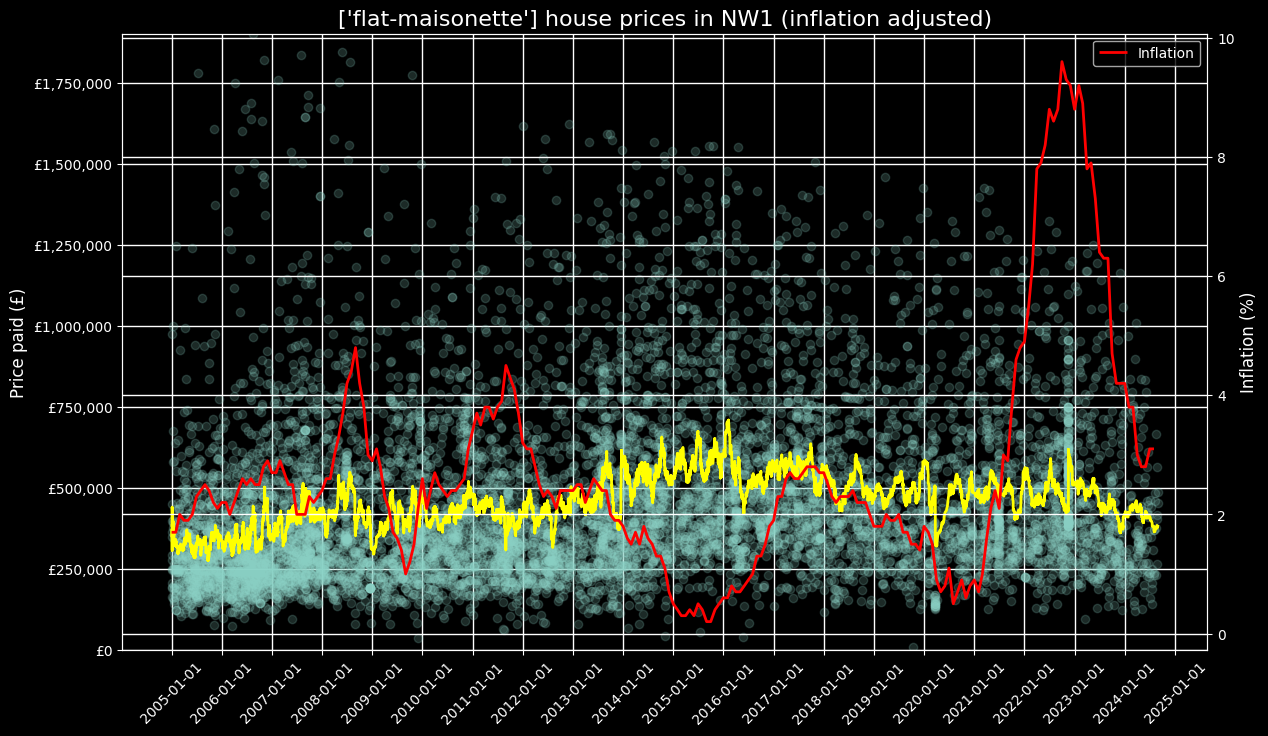

In [ ]:
# Plot results

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use('dark_background')

fig, ax = plt.subplots(1, 1, figsize=(14, 8))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Start x axis at zero
ax.set_ylim(0, house_prices['pricePaid'].max())

ax.tick_params(axis='x', rotation=45)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "£{:,}".format(int(x))))

ax.plot(house_prices['transactionDate'], house_prices['moving_avg'], color='yellow', linestyle='-',
        label="Price paid (moving avg.")
ax.scatter(house_prices['transactionDate'], house_prices['pricePaid'], alpha=0.2)
ax.grid(True)
ax.set_ylabel('Price paid (£)')

ax2 = ax.twinx()
ax2.set_ylabel('Inflation (%)')
ax2.plot(inf['date'], inf['rate'], color="red", label="Inflation")

plt.legend()

plt.title(f"{property_types} house prices in {postcode} {'(inflation adjusted)' if inflation_adjust else ''}")

plt.show()

In [ ]:
# Process S&P data
# TODO: Include FX rates in this calculation

import urllib.request

snp = []

# Read s&p data from s&p.json
with urllib.request.urlopen('https://hcee-static-prod.s3.eu-west-2.amazonaws.com/docs/s%26p.json') as f:
    d = json.load(f)
    for i, t in enumerate(d["timestamp"]):
        snp.append((pd.to_datetime(t, unit='s'), d["close"][i]))

snp = pd.DataFrame(snp, columns=['date', 'close'])

snp['date'] = pd.to_datetime(snp['date'])
snp = snp[snp["date"] >= pd.to_datetime(f"{start_year}-01-01")]

snp["month"] = snp["date"].dt.month
snp["year"] = snp["date"].dt.year
snp["snp_total_return_index"] = snp["close"] / snp["close"].iloc[0] * 100

if inflation_adjust:
    snp = snp.merge(inf, on=["month", "year"])
    snp["snp_total_return_index"] = snp["snp_total_return_index"] / snp["cumulative"]

In [ ]:
# Index everything and include rental return
monthly_rental_yield = (1 + rental_yield) ** (1 / 12) - 1

indexed = pd.DataFrame(house_prices.groupby(["year", "month"])["pricePaid"].mean())

indexed["property_price_index"] = indexed["pricePaid"] / indexed["pricePaid"].iloc[0] * 100
indexed["rental_return_index"] = (indexed["property_price_index"] * monthly_rental_yield).cumsum()
indexed["total_property_return_index"] = indexed["property_price_index"] + indexed["rental_return_index"]

# Merge snp return and inflation numbers
indexed = indexed.merge(snp, on=["year", "month"])
indexed = indexed.merge(inf, on=["month", "year"])

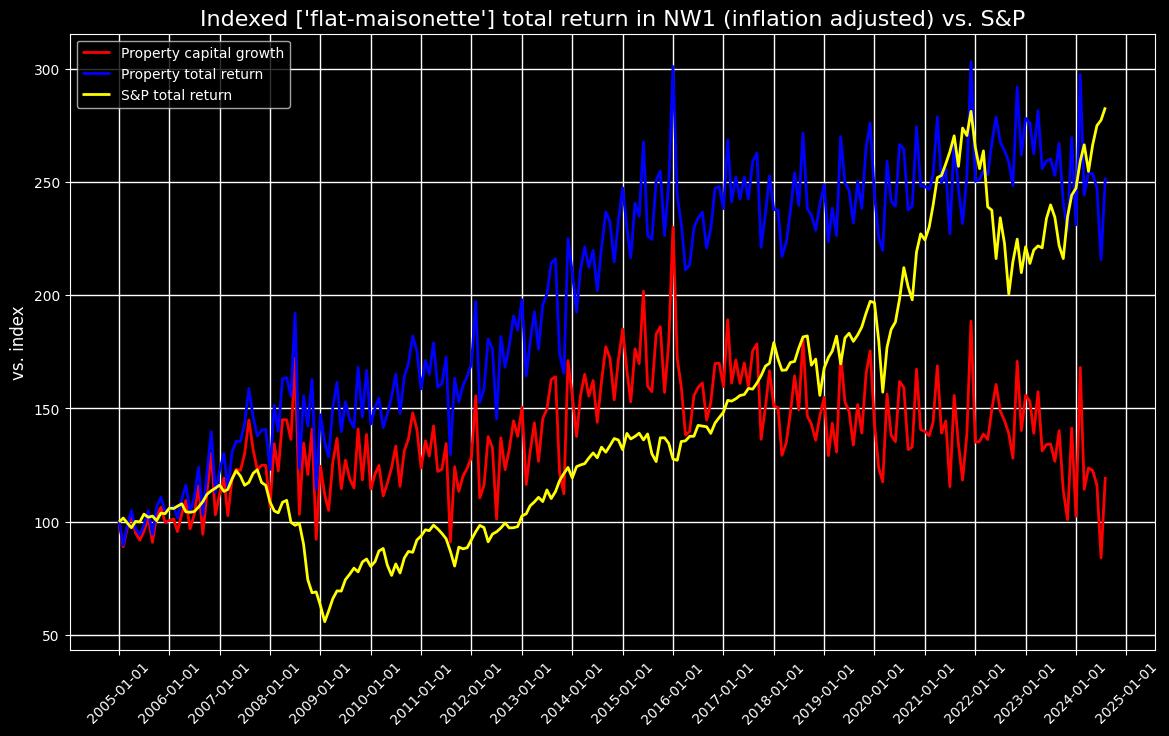

In [ ]:
# Plot indexed results
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

ax.tick_params(axis='x', rotation=45)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

ax.plot(indexed['date_x'], indexed['property_price_index'], color='red', linestyle='-', label='Property capital growth')
ax.plot(indexed['date_x'], indexed['total_property_return_index'], color='blue', linestyle='-', label='Property total return')
ax.plot(indexed['date_x'], indexed['snp_total_return_index'], color='yellow', linestyle='-', label='S&P total return')

# Uncomment to show inflation
# ax2 = ax.twinx()
# ax2.set_ylabel('Inflation (%)')
# ax2.plot(inf['date'], inf['rate'], color='red')

ax.grid(True)
ax.legend()
ax.set_ylabel('vs. index')

plt.title(
    f"Indexed {property_types} total return in {postcode} {'(inflation adjusted)' if inflation_adjust else ''} vs. S&P")

plt.show()

This graph is sensitive to initial conditions. Indexing from 2007 (when US shares were relatively expensive, even vs. housing) yields a much better showing for property than starting in say 2016, as the bull market in equities really got going and property prices stagnated.

Note that I've made no attempts to model the effects of mortgage borrowing so far. Assuming that you can't borrow to fund your alternative investments (and ignoring interest on the mortgage), they have the effect of increasing the gradient of the property capital growth and total return trajectories vs. other investments.